In [1]:
%matplotlib widget
%cd /data/seismo/kashyap/codes/p11-seismo-xl

/data/seismo/kashyap/codes/p11-seismo-xl


In [2]:
%run analyze_8006161.py --help

usage: analyze_8006161.py [-h] [--Navg NAVG] [--Nshift NSHIFT]
                          [--inclang INCLANG] [--freqmin FREQMIN]
                          [--freqmax FREQMAX]

Process some integers.

optional arguments:
  -h, --help         show this help message and exit
  --Navg NAVG        Length of sub-series (days)
  --Nshift NSHIFT    Shift between sub-series (days)
  --inclang INCLANG  Inclination angle
  --freqmin FREQMIN  Minimum freq in mHz
  --freqmax FREQMAX  Maximum freq in mHz


LOADING SUCESS
(90979,)
(90979,)
----Number of frequency bins = 77760


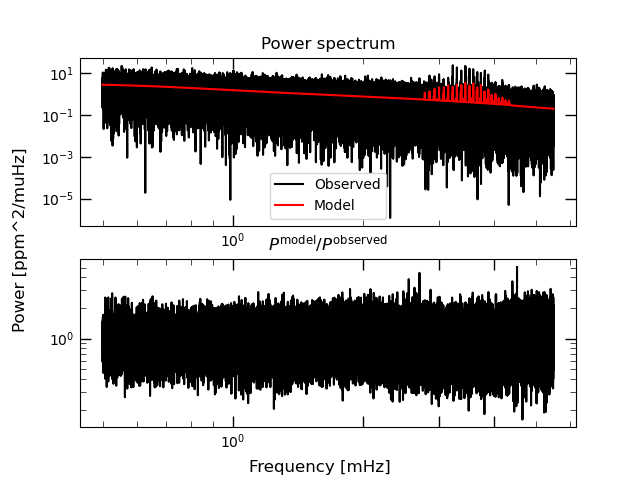

In [66]:
%run analyze_8006161.py --Navg 180 --Nshift 45

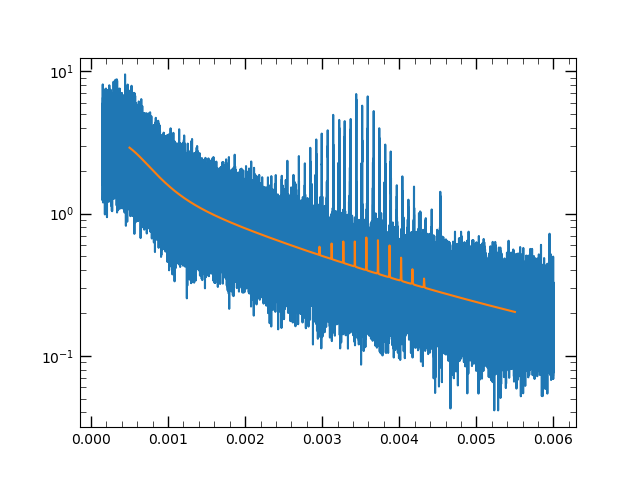

In [68]:
plt.figure()
plt.semilogy(fref, pref)
plt.semilogy(freq_arr, psl_bg[-1] + amps[mask3] @ psl_bg[:-1][mask3])

In [69]:
a2g = amps*amps/fwhm

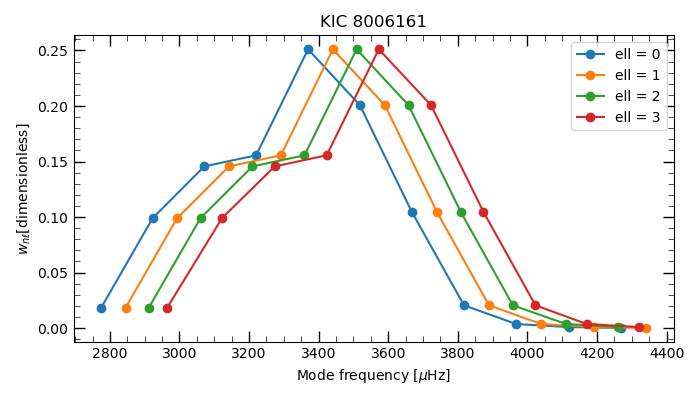

In [70]:
fig, axs = plt.subplots(figsize=(7, 4))
for ell, _mask in enumerate([mask0, mask1, mask2, mask3]):
    wnl = a2g[_mask]/a2g[_mask].sum()
    _nu = nus[_mask]*1e6
    axs.plot(_nu, wnl, '-o', label=f'ell = {ell}')
axs.set_xlabel('Mode frequency [$\\mu$Hz]')
axs.set_ylabel('$w_{n\\ell}$' + '[dimensionless]')
axs.legend()
axs.set_title('KIC 8006161')
fig.tight_layout()

In [71]:
def get_freqlags_corrected(refarr, pfilt_list, pexcl_list, maxlag=20):
    # print(f"max frequency lag = {maxlag*dfreq:.2f} muHz")
    
    # corr_mat stores the correlation matrix [ell, time_chunk, lag]
    # corr_mat_gauss stores the gaussian fit [ell, time_chunk, lag]
    # corr_matarg stores the index corresponding to maximum corr [ell, time_chunk]
    # corr_matarg_gauss max corr for the gaussian fit [ell, time_chunk]
    
    corr_mat = np.zeros((4, 2*maxlag+1))
    corr_mat_gauss = np.zeros((4, 2*maxlag+1))
    corr_matarg = np.zeros(4)
    corr_matarg_gauss = np.zeros(4)
    
    lags_list, corr_list, corrnlist, corrbg_list = [], [], [], []
    for jdx in range(pfilt_list.shape[0]):
        p0 = [1., 0., 1., 0.]
        coeff = [0., 0., 0., 0.]
        lags, corr = compute_cc(pfilt_list[jdx], refarr, maxlag=maxlag)
        lags_bg, corr_bg = compute_cc(pexcl_list[jdx], pfilt_list[jdx], maxlag=maxlag)
        corr = corr + corr_bg
        try:
            coeff, var_matrix = curve_fit(gaussian, lags, corr, p0=p0)
        except RuntimeError:
            coeff[1] = np.nan
        corr_mat_gauss[jdx, :] = gaussian(lags, *coeff)
        corr_mat[jdx, :] = corr
        max_idx = np.argmax(corr)
        corr_matarg[jdx] = lags[max_idx]
        corr_matarg_gauss[jdx] = coeff[1]
        corrbg_list.append(corr_bg)
    return (corr_mat, corr_mat_gauss), (corr_matarg, corr_matarg_gauss), corrbg_list

In [82]:
dfreq = freq_arr[1] - freq_arr[0]
maxlag = 28
p0 = [1., 0., 1., 0.]
print(f"max frequency lag = {maxlag*dfreq:.2f} muHz")
lags = np.arange(-maxlag, maxlag+1)

corr_mat = np.zeros((4, pschunks.shape[0], 2*maxlag+1))
corr_mat_gauss = np.zeros((4, pschunks.shape[0], 2*maxlag+1))
corr_matarg = np.zeros((4, pschunks.shape[0]))
corr_matarg_gauss = np.zeros((4, pschunks.shape[0]))

for idx in tqdm(range(pschunks.shape[0]), desc="Time index=", leave=True):
    lags_list, corr_list, corrnlist = [], [], []
    (_cm, _cmg), (_cma, _cmag), _cbg_list = get_freqlags_corrected(pschunks[idx], pfilt_list, pexcl_list, maxlag=maxlag)
    corr_mat[:, idx, :] = _cm
    corr_mat_gauss[:, idx, :] = _cmg
    corr_matarg[:, idx] = _cma
    corr_matarg_gauss[:, idx] = _cmag

max frequency lag = 0.00 muHz


Time index=: 100%|██████████| 22/22 [00:01<00:00, 21.44it/s]


Text(0.02, 0.5, '$\\bar{\\delta\\nu}_\\ell$ in $\\mu$Hz')

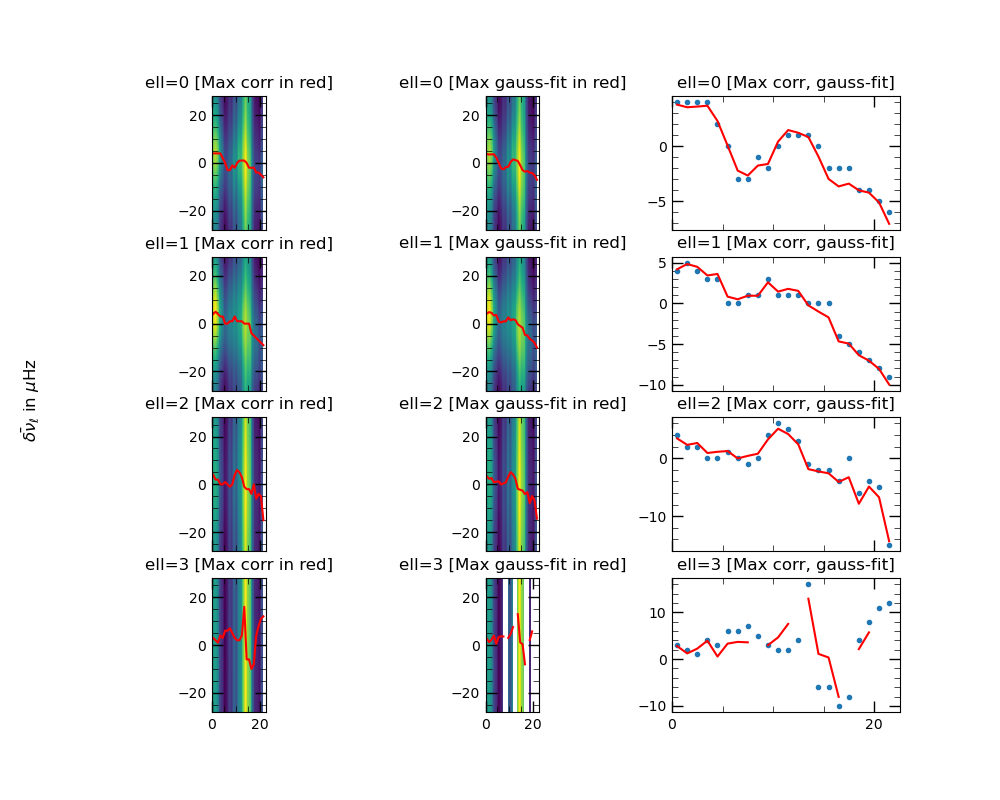

In [83]:
xax = np.arange(pschunks.shape[0])
fig, axs = plt.subplots(nrows=4, ncols=3, sharex=True, figsize=(10, 8))
axs[0, 0].imshow(corr_mat[0].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[0, 0].plot(xax+0.5, corr_matarg[0], 'r')
axs[1, 0].imshow(corr_mat[1].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[1, 0].plot(xax+0.5, corr_matarg[1], 'r')
axs[2, 0].imshow(corr_mat[2].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[2, 0].plot(xax+0.5, corr_matarg[2], 'r')
axs[3, 0].imshow(corr_mat[3].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[3, 0].plot(xax+0.5, corr_matarg[3], 'r')

axs[0, 1].imshow(corr_mat_gauss[0].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[0, 1].plot(xax+0.5, corr_matarg_gauss[0], 'r')
axs[1, 1].imshow(corr_mat_gauss[1].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[1, 1].plot(xax+0.5, corr_matarg_gauss[1], 'r')
axs[2, 1].imshow(corr_mat_gauss[2].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[2, 1].plot(xax+0.5, corr_matarg_gauss[2], 'r')
axs[3, 1].imshow(corr_mat_gauss[3].T, extent=[0, xax.max(), -maxlag, maxlag,], origin='lower'); axs[3, 1].plot(xax+0.5, corr_matarg_gauss[3], 'r')

axs[0, 2].plot(xax+0.5, corr_matarg[0], '.'); axs[0, 2].plot(xax+0.5, corr_matarg_gauss[0], '-r')
axs[1, 2].plot(xax+0.5, corr_matarg[1], '.'); axs[1, 2].plot(xax+0.5, corr_matarg_gauss[1], '-r')
axs[2, 2].plot(xax+0.5, corr_matarg[2], '.'); axs[2, 2].plot(xax+0.5, corr_matarg_gauss[2], '-r')
axs[3, 2].plot(xax+0.5, corr_matarg[3], '.'); axs[3, 2].plot(xax+0.5, corr_matarg_gauss[3], '-r')
for idx in range(4): 
    axs[idx, 0].set_title(f'ell={idx} [Max corr in red]')
    axs[idx, 1].set_title(f'ell={idx} [Max gauss-fit in red]')
    axs[idx, 2].set_title(f'ell={idx} [Max corr, gauss-fit]')
fig.supylabel('$\\bar{\\delta\\nu}_\\ell$ in $\\mu$Hz')

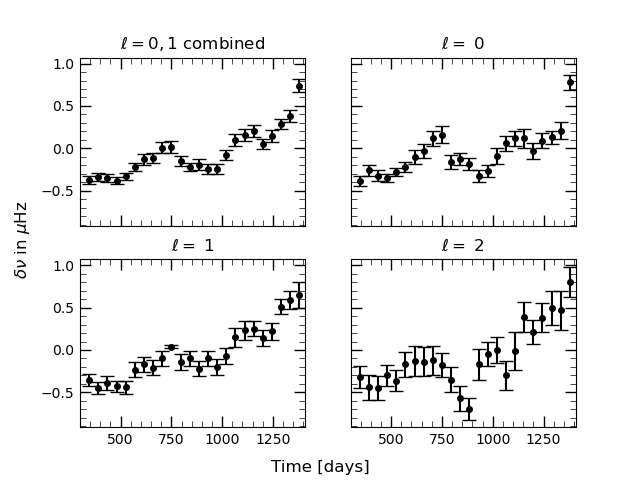

In [84]:
import pandas as pd
data = pd.read_csv('data/8006161.csv')
data
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.flatten()
axs[0].errorbar(data['time'], data['delnu'],  yerr=data['delnu_error'],  capsize=5, color='k', marker='o', markersize=4, linestyle='')
axs[1].errorbar(data['time'], data['delnu0'], yerr=data['delnu0_error'], capsize=5, color='k', marker='o', markersize=4, linestyle='')
axs[2].errorbar(data['time'], data['delnu1'], yerr=data['delnu1_error'], capsize=5, color='k', marker='o', markersize=4, linestyle='')
axs[3].errorbar(data['time'], data['delnu2'], yerr=data['delnu2_error'], capsize=5, color='k', marker='o', markersize=4, linestyle='')
axs[0].set_title('$\\ell = 0, 1$ combined')
for idx in range(3):
    axs[idx+1].set_title('$\\ell=$ ' + f'{idx}')
fig.supxlabel('Time [days]')
fig.supylabel('$\\delta\\nu$ in $\\mu$Hz')
axs[0].set_xlim([300, 1410])
plt.show()


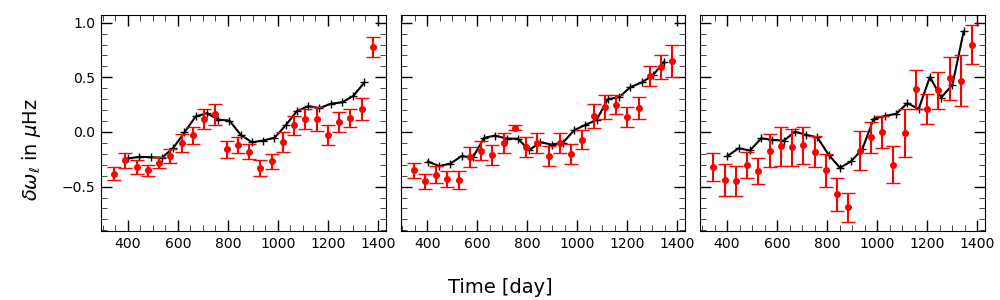

In [85]:
time_arr = np.load(f"/data/seismo/kashyap/codes/p11-seismo-xl/data/tmid-8006161-N{ARGS.Navg}-s{ARGS.Nshift}.npy")
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), sharex=True, sharey=True)
for idx in range(3):
    axs[idx].plot(time_arr, -corr_matarg_gauss[idx]*dfreq*1e6, '+-k')
axs[0].errorbar(data['time'], data['delnu0'], yerr=data['delnu0_error'], capsize=5, color='r', marker='o', markersize=4, linestyle='')
axs[1].errorbar(data['time'], data['delnu1'], yerr=data['delnu1_error'], capsize=5, color='r', marker='o', markersize=4, linestyle='')
axs[2].errorbar(data['time'], data['delnu2'], yerr=data['delnu2_error'], capsize=5, color='r', marker='o', markersize=4, linestyle='')    
fig.supxlabel('Time [day]', fontsize=14)
fig.supylabel('$\\delta\\omega_\\ell$ in $\\mu$Hz', fontsize=14)
fig.tight_layout()

In [86]:
plt.close('all')

In [87]:
corr_matarg_gauss[0]

array([ 3.76869861,  3.53076616,  3.59337557,  3.67104509,  2.28256892,
        0.04996323, -2.22015489, -2.66845528, -1.76153604, -1.61671725,
        0.41683198,  1.45938087,  1.21654652,  0.82536538, -0.94512261,
       -2.97491739, -3.65676625, -3.40056934, -4.0087586 , -4.22250998,
       -5.11043361, -7.05165878])